In [31]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import floatpy.readers.padeops_reader as por
import floatpy.readers.parallel_reader as pdr
import floatpy.utilities.reduction as red
import floatpy.derivatives.compact.compact_derivative as cd
import scripts.statistics as stats
import scripts.get_namelist as nml

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/256x512x128/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/512x724x256/'
directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/1024x1448x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc04/rr1/256x512x128/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc04/rr1/1024x1448x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc07/rr1/724x1024x362/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr1/512x724x256/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr1/1024x1024x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr7/1024x1448x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc12/rr1/256x384x128/with_LAD/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc12/rr1/724x724x256/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc12/rr1/1024x1024x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc12/rr1/1024x1448x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc16/rr1/1024x1448x512/'

directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512/'

inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)


Note: Missing D# multiplier for line:
	Re      = 1000           ! Reynolds number rho_Ref*dU*L/mu_ref
	Assuming multiplier is 1.

Params for this run:
	Mc = 2.0
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024.0x1448.0x512.0
	L = 80.0x80.0x40.0


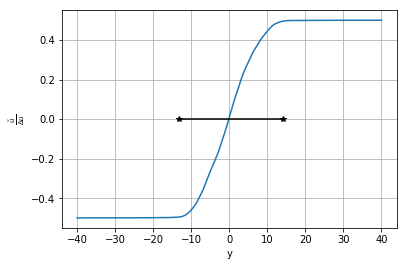

In [53]:
# 99% thickness
du = inp.du
utop = 0.99*du/2
ubot = -0.99*du/2

def get_L99(directory,tID,plotOpt=1):
    fname = directory + 'shearlayer_utilde_'+str(tID)+'.dat'
    dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
    n = np.size(dat)
    nstats=1
    dat = np.reshape(dat,[n/nstats,nstats])
    utilde = dat[:,0]
    
    i1 = np.argmin(abs(utilde[:Ny/2]-ubot))
    i2 = np.argmin(abs(utilde[Ny/2:]-utop)) + Ny/2
    L99 = (y[i2]-y[i1])
    
    if plotOpt:
        plt.plot(y,utilde/du)
        plt.plot([y[i1],y[i2]],[0,0],'k-*')
        plt.grid(True)
        plt.xlabel('y')
        plt.ylabel(r'$\frac{\tilde{u}}{\Delta u}$')
    return L99

# L99 = get_L99(directory,'0008')


(118, 606)
Integral Ly = 67.007601935
L_int/L99 = 2.4584178499


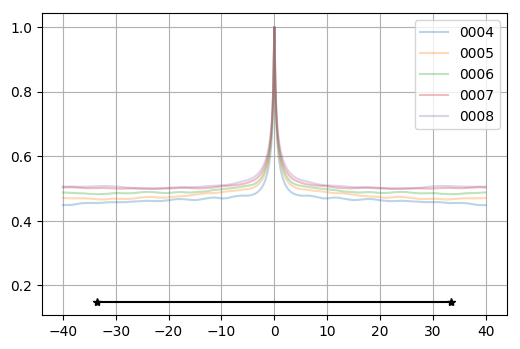

In [55]:
# vv correlation profiles
fig = plt.figure(dpi=100)

flist = glob.glob(directory+"*lscale_pp*")
Lvv_mean = 0;
count=0
for fname in flist[:]:
    tID = fname.split('_')[-1]
    tID = tID.split('.dat')[0]
    
    dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
    Lvv = np.fft.fftshift(dat)
    
    L99 = get_L99(directory,tID,plotOpt=0)
    
    plt.plot(y, Lvv, alpha=0.3,label=str(tID))
    Lvv_mean += Lvv
    count+=1;
Lvv_mean /= count

# Get lengthscale
thresh = 0.15
i1 = np.argmin(abs(Lvv_mean[:Ny/2]-thresh))
i2 = np.argmin(abs(Lvv_mean[Ny/2:]-thresh))
L_int = abs(y[i1]-y[Ny/2+i2])
plt.plot([y[i1],y[Ny/2+i2]],[thresh,thresh],'k-*')
plt.grid(True)
plt.legend()

print(i1,i2)
print("Integral Ly = {}".format(L_int))
print("L_int/L99 = {}".format(L_int/L99))

Text(0,0.5,'$b_{12}(0)$')

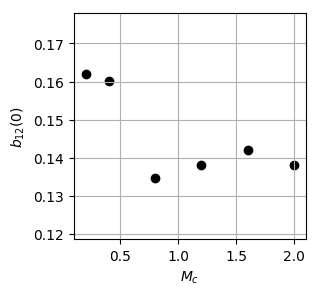

In [179]:
ly_norm = { #using vv
    #0.2: 1.3, #256x512, step 40
    0.2: 1.41, #512x724, step 60
    0.4: 1.148, # 256x512, step 30
    #0.8: 1.056, # 512x724, step 5
#     0.8: 0.9761, # 1024x1024, step 40
    #1.2: 0.659 # 724x724, step 10, thresh = ?
    #1.2: 0.784, # 1024x1024, step 17, thresh=0.15
    1.2: 0.749003963021, #1024x1448, step 5, thresh 0.15
    1.6: 0.656716405221, # step 5, thresh 0.15
    2.0: 0.557291677905 # step 5, thresh 0.15
}
fs = 14
fig = plt.figure(figsize=(3,3),dpi=200)
plt.scatter(ly_norm.keys(),ly_norm.values(),c='k')
plt.grid(True)
plt.xlabel(r'$M_c$')
plt.ylabel(r'$L/\delta_{99}$')
